In [1]:
# !pip install pycocotools --quiet
# !git clone https://github.com/pytorch/vision.git
# !git checkout v0.3.0

# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

In [2]:
import os
import numpy as np
import torch as tc
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm, trange
import pickle

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
# import transforms as T
#import cv2
from WishDataSet import WishTubeFrameDataSet, get_transform
from wish_utils import *

In [3]:
tc.__version__

'2.2.1+cu118'

In [4]:
tc.cuda.is_available(), tc.cuda.device_count()

(True, 1)

In [5]:
!nvidia-smi

Fri Apr 19 16:25:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:04:00.0 Off |                  N/A |
| 30%   43C    P8             18W /  125W |     254MiB /   8192MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
tc.cuda.current_device(), tc.cuda.device(0), tc.cuda.get_device_name()

(0, <torch.cuda.device at 0x7fc3cf9f6e60>, 'Quadro RTX 4000')

In [7]:
annotations_dir = "/home/wj1132075/Desktop/CNN_Model_Data/TubeByTube/Annotations/"
ds = WishTubeFrameDataSet(annotations_dir)
len(ds)

3131

In [8]:
def plot_tube_frame_with_bbox(image, target):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cs = plt.contourf(image[..., 0])
    plt.colorbar(cs)    
    for xmin, ymin, xmax, ymax in target['boxes']:
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin),
                                 width, height,
                                 linewidth = 0.4,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        ax.add_patch(rect)
    plt.show()

### See tube frames and boxes

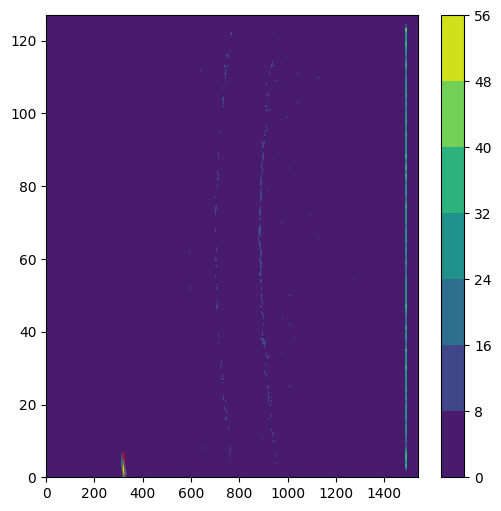

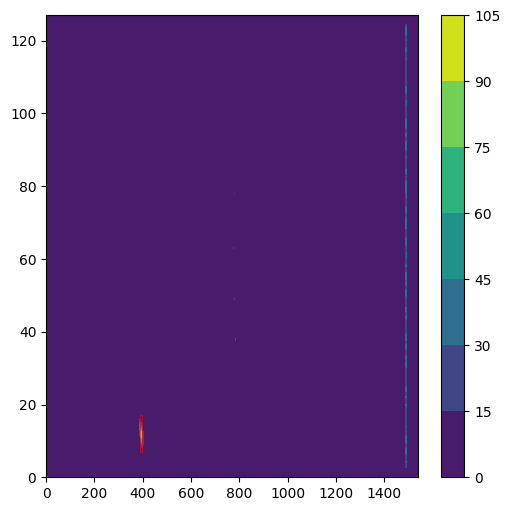

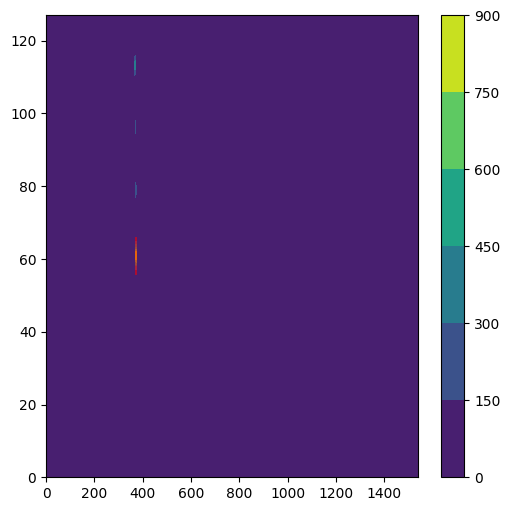

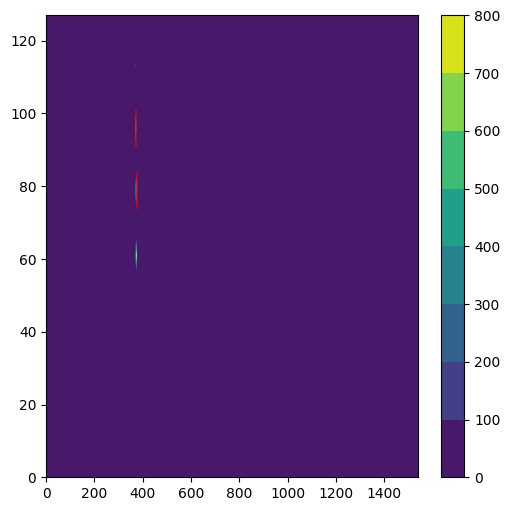

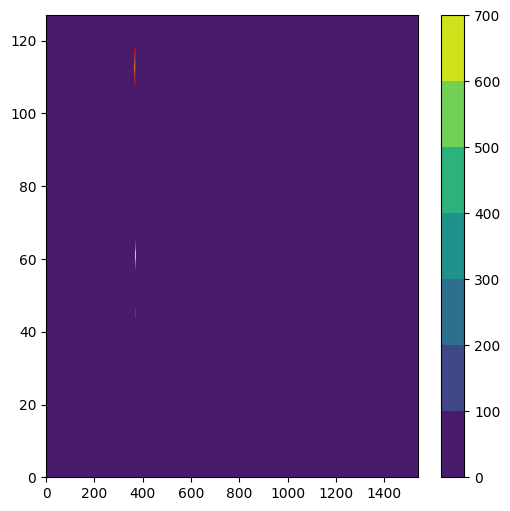

In [9]:
i=0
for (im, tar) in ds:
    plot_tube_frame_with_bbox(im, tar)
    i+=1
    if i == 5:
        break

### Calculate the stats

In [10]:
# dl = tc.utils.data.DataLoader(ds, batch_size=100, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)
# stats = get_stats(dl)
# stats

In [11]:
# stats = (np.array([1.26653515, 1.26653515, 1.26653515]), np.array([4.59509826, 4.59509826, 4.59509826]))
# stats

### Training and test data sets

In [12]:
# use our dataset and defined transformations
stats=None
dataset = WishTubeFrameDataSet(annotations_dir, transforms=get_transform(train=True))
dataset_test = WishTubeFrameDataSet(annotations_dir, transforms=get_transform(train=False))

In [13]:
# split the dataset in train and test set
tc.manual_seed(1)
indices = tc.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = tc.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = tc.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = tc.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
data_loader_test = tc.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=2, collate_fn=utils.collate_fn)

In [14]:
dir(torchvision.models.detection)

['FCOS',
 'FCOS_ResNet50_FPN_Weights',
 'FasterRCNN',
 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights',
 'FasterRCNN_MobileNet_V3_Large_FPN_Weights',
 'FasterRCNN_ResNet50_FPN_V2_Weights',
 'FasterRCNN_ResNet50_FPN_Weights',
 'KeypointRCNN',
 'KeypointRCNN_ResNet50_FPN_Weights',
 'MaskRCNN',
 'MaskRCNN_ResNet50_FPN_V2_Weights',
 'MaskRCNN_ResNet50_FPN_Weights',
 'RetinaNet',
 'RetinaNet_ResNet50_FPN_V2_Weights',
 'RetinaNet_ResNet50_FPN_Weights',
 'SSD300_VGG16_Weights',
 'SSDLite320_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'anchor_utils',
 'backbone_utils',
 'faster_rcnn',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos',
 'fcos_resnet50_fpn',
 'generalized_rcnn',
 'image_list',
 'keypoint_rcnn',
 'keypointrcnn_resnet50_fpn',
 'mask_rcnn',
 'maskrcnn_resnet50_fpn'

In [15]:
model=torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(wights=None)

In [16]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [17]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2) 

In [18]:
p=[p.requires_grad for p in model.parameters()]
len(p)

209

### Model Training

In [19]:
# to train on gpu if selected.
device = tc.device('cuda') if tc.cuda.is_available() else tc.device('cpu')
freeze_to(model, False)

In [20]:
p=[p.requires_grad for p in model.parameters()]
len(p)

209

In [21]:
# model

In [22]:
dir(tc.optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [23]:
dir(tc.optim.lr_scheduler)

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LRScheduler',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 '_LRScheduler',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_check_verbose_deprecated_warning',
 '_enable_get_lr_call',
 'bisect_right',
 'inf',
 'math',
 'partial',
 'types',
 'warnings',
 'weakref',
 'wraps']

In [24]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = tc.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# optimizer = tc.optim.Adam(params, lr=0.001)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = tc.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=3,
                                            gamma=0.1)# to train on gpu if selected.

In [25]:
params[-5:]

[Parameter containing:
 tensor([ 0.0031, -0.0041, -0.0021,  ..., -0.0075, -0.0012,  0.0030],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0210,  0.0040,  0.0267,  ...,  0.0165,  0.0286,  0.0296],
         [-0.0210, -0.0177,  0.0283,  ..., -0.0210,  0.0179,  0.0117]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0083,  0.0174], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.0307,  0.0234,  0.0224,  ..., -0.0174, -0.0275,  0.0036],
         [-0.0048, -0.0041, -0.0255,  ...,  0.0019,  0.0176, -0.0070],
         [-0.0161, -0.0248,  0.0263,  ..., -0.0207,  0.0289,  0.0287],
         ...,
         [ 0.0141, -0.0246,  0.0112,  ..., -0.0213, -0.0094, -0.0191],
         [ 0.0214,  0.0155, -0.0005,  ..., -0.0007,  0.0119, -0.0108],
         [-0.0221, -0.0289, -0.0085,  ..., -0.0155, -0.0222,  0.0075]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0225, -0.0302, 

In [26]:
len(params)

209

In [27]:
lr_scheduler

### Training 

In [28]:
num_epochs = 20

for epoch in trange(num_epochs):
    # training for one epoch
    print(f"starting epoch {epoch}")
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

starting epoch 0
Epoch: [0]  [  0/314]  eta: 0:07:31  lr: 0.000021  loss: 2.6939 (2.6939)  loss_classifier: 0.8266 (0.8266)  loss_box_reg: 0.0050 (0.0050)  loss_objectness: 0.6994 (0.6994)  loss_rpn_box_reg: 1.1629 (1.1629)  time: 1.4373  data: 0.2205  max mem: 6113
Epoch: [0]  [ 50/314]  eta: 0:04:43  lr: 0.000819  loss: 1.3715 (1.7908)  loss_classifier: 0.0819 (0.2797)  loss_box_reg: 0.0084 (0.0064)  loss_objectness: 0.5926 (0.6452)  loss_rpn_box_reg: 0.6572 (0.8594)  time: 1.0812  data: 0.0181  max mem: 6279
Epoch: [0]  [100/314]  eta: 0:03:47  lr: 0.001617  loss: 1.0136 (1.4492)  loss_classifier: 0.0266 (0.1642)  loss_box_reg: 0.0201 (0.0123)  loss_objectness: 0.5242 (0.5963)  loss_rpn_box_reg: 0.4301 (0.6764)  time: 1.0493  data: 0.0187  max mem: 6279
Epoch: [0]  [150/314]  eta: 0:02:55  lr: 0.002415  loss: 0.7620 (1.2517)  loss_classifier: 0.0307 (0.1194)  loss_box_reg: 0.0357 (0.0193)  loss_objectness: 0.4579 (0.5599)  loss_rpn_box_reg: 0.2185 (0.5530)  time: 1.1006  data: 0.018

#### Save the trained model

In [29]:
model_save_path = '/mnt/ceph/home/wj1132075/Desktop/CNN_Model_Data/tube_by_tube_fasterrcnn_mobilenet_v3_large_320_fpn.pt'

In [30]:
tc.save(model.state_dict(), model_save_path)

### Load the model from disk

In [32]:
r_model = get_object_detection_model(2)
# r_model.load_state_dict(tc.load(model_save_path))
r_model.load_state_dict(tc.load(model_save_path, map_location=tc.device('cpu')))
r_model = r_model.to(device)

/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wj1132075/.conda/envs/cuda_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	Missing key(s) in state_dict: "backbone.fpn.inner_blocks.0.0.bias", "backbone.fpn.inner_blocks.1.0.bias", "backbone.fpn.inner_blocks.2.0.bias", "backbone.fpn.inner_blocks.3.0.bias", "backbone.fpn.layer_blocks.0.0.bias", "backbone.fpn.layer_blocks.1.0.bias", "backbone.fpn.layer_blocks.2.0.bias", "backbone.fpn.layer_blocks.3.0.bias", "roi_heads.box_head.fc6.weight", "roi_heads.box_head.fc6.bias", "roi_heads.box_head.fc7.weight", "roi_heads.box_head.fc7.bias". 
	Unexpected key(s) in state_dict: "backbone.fpn.inner_blocks.0.1.weight", "backbone.fpn.inner_blocks.0.1.bias", "backbone.fpn.inner_blocks.0.1.running_mean", "backbone.fpn.inner_blocks.0.1.running_var", "backbone.fpn.inner_blocks.0.1.num_batches_tracked", "backbone.fpn.inner_blocks.1.1.weight", "backbone.fpn.inner_blocks.1.1.bias", "backbone.fpn.inner_blocks.1.1.running_mean", "backbone.fpn.inner_blocks.1.1.running_var", "backbone.fpn.inner_blocks.1.1.num_batches_tracked", "backbone.fpn.inner_blocks.2.1.weight", "backbone.fpn.inner_blocks.2.1.bias", "backbone.fpn.inner_blocks.2.1.running_mean", "backbone.fpn.inner_blocks.2.1.running_var", "backbone.fpn.inner_blocks.2.1.num_batches_tracked", "backbone.fpn.inner_blocks.3.1.weight", "backbone.fpn.inner_blocks.3.1.bias", "backbone.fpn.inner_blocks.3.1.running_mean", "backbone.fpn.inner_blocks.3.1.running_var", "backbone.fpn.inner_blocks.3.1.num_batches_tracked", "backbone.fpn.layer_blocks.0.1.weight", "backbone.fpn.layer_blocks.0.1.bias", "backbone.fpn.layer_blocks.0.1.running_mean", "backbone.fpn.layer_blocks.0.1.running_var", "backbone.fpn.layer_blocks.0.1.num_batches_tracked", "backbone.fpn.layer_blocks.1.1.weight", "backbone.fpn.layer_blocks.1.1.bias", "backbone.fpn.layer_blocks.1.1.running_mean", "backbone.fpn.layer_blocks.1.1.running_var", "backbone.fpn.layer_blocks.1.1.num_batches_tracked", "backbone.fpn.layer_blocks.2.1.weight", "backbone.fpn.layer_blocks.2.1.bias", "backbone.fpn.layer_blocks.2.1.running_mean", "backbone.fpn.layer_blocks.2.1.running_var", "backbone.fpn.layer_blocks.2.1.num_batches_tracked", "backbone.fpn.layer_blocks.3.1.weight", "backbone.fpn.layer_blocks.3.1.bias", "backbone.fpn.layer_blocks.3.1.running_mean", "backbone.fpn.layer_blocks.3.1.running_var", "backbone.fpn.layer_blocks.3.1.num_batches_tracked", "rpn.head.conv.1.0.weight", "rpn.head.conv.1.0.bias", "roi_heads.box_head.0.0.weight", "roi_heads.box_head.0.1.weight", "roi_heads.box_head.0.1.bias", "roi_heads.box_head.0.1.running_mean", "roi_heads.box_head.0.1.running_var", "roi_heads.box_head.0.1.num_batches_tracked", "roi_heads.box_head.1.0.weight", "roi_heads.box_head.1.1.weight", "roi_heads.box_head.1.1.bias", "roi_heads.box_head.1.1.running_mean", "roi_heads.box_head.1.1.running_var", "roi_heads.box_head.1.1.num_batches_tracked", "roi_heads.box_head.2.0.weight", "roi_heads.box_head.2.1.weight", "roi_heads.box_head.2.1.bias", "roi_heads.box_head.2.1.running_mean", "roi_heads.box_head.2.1.running_var", "roi_heads.box_head.2.1.num_batches_tracked", "roi_heads.box_head.3.0.weight", "roi_heads.box_head.3.1.weight", "roi_heads.box_head.3.1.bias", "roi_heads.box_head.3.1.running_mean", "roi_heads.box_head.3.1.running_var", "roi_heads.box_head.3.1.num_batches_tracked", "roi_heads.box_head.5.weight", "roi_heads.box_head.5.bias". 

In [ ]:
def plot_frame_detections(bin_data, real_boxes, predicted_boxes, score_threshold = 0.75):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cs = plt.contourf(bin_data)
    plt.colorbar(cs)
    for box in real_boxes.cpu():
        det_x, det_y = (box[0]+box[2])/2, (box[1]+box[3])/2
        plt.plot(det_x, det_y, marker="x", markersize=9, markeredgecolor="lime", markerfacecolor="lime")
        
    plotted_predictions = 0
    for box, score in zip(predicted_boxes['boxes'].cpu(), predicted_boxes['scores'].cpu()):
        print(f"prediction={box} score={score}")
        x_hat, y_hat = (box[0]+box[2])/2, (box[1]+box[3])/2
        if score < score_threshold:
            print(f"----->Ignoring the prediction at x={x_hat} y={y_hat} with score={score}")
            plt.plot(x_hat, y_hat, marker="x", markersize=5, markeredgecolor="white", markerfacecolor="white")
            continue
            
        print(f"Prediction coordinate x={x_hat} y={y_hat}")
        plt.plot(x_hat, y_hat, marker="x", markersize=5, markeredgecolor="red", markerfacecolor="red")
        plotted_predictions += 1

    plt.title(f"Predicted-{plotted_predictions} vs Real-{len(real_boxes)}")
    plt.show()

In [ ]:
r_model.eval()
probe = 0
for img, target in data_loader_test:
    imgs = list(img)
    targets = list(target)
    with tc.no_grad():
        for img, target in zip(imgs, targets):
            prediction = r_model([img.to(device)])[0]
            nms_prediction = apply_nms(prediction, iou_thresh=0.001)
            print(nms_prediction)
            plot_frame_detections(img[0,:,:], target['boxes'], nms_prediction)
            probe += 1

    if probe >= 10:
        break